In [1]:
import numpy as np  

T = 1  # Initial temperature
N = 100  # Number of particles
iter = 100  # Number of simulation steps
Lx = 20  # Box length in x-direction
Ly = 10  # Box length in y-direction
epsilon = 1  # Lennard-Jones potential depth
siagma = 1  # Lennard-Jones distance scale 
rc = 2.5 * siagma  # Cutoff radius for LJ potential
displacment = []  # List to store initial particle positions
delta_t = 0.001  # Time step 

# Initialize positions on a 2D square grid in the left half of the box
for i in range(1, int(Lx / 2) + 1):
    for j in range(1, int(Lx / 2) + 1):
        displacment.append((i, j))

# Initialize velocities with normal distribution (Maxwell-Boltzmann at temp T)
x_velocity = np.random.normal(0, np.sqrt(T), N)
y_velocity = np.random.normal(0, np.sqrt(T), N)

# Subtract mean to ensure center-of-mass velocity is zero 
x_velocity -= np.mean(x_velocity)
y_velocity -= np.mean(y_velocity)

velocity = []  # Create velocity array
for i in range(x_velocity.shape[0]):
    velocity.append([x_velocity[i], y_velocity[i]])
velocity = np.array(velocity)  # Convert to NumPy array for fast vector ops


In [ ]:
def force_compute(x1, y1, x2, y2):
    # Compute minimum image distance in x under periodic boundary (box length hardcoded as 10)
    x = np.min([abs(x2 - x1), 10 - abs(x2 - x1)])  
    
    # Compute minimum image distance in y (also with box length = 10)
    y = np.min([abs(y2 - y1), 10 - abs(y2 - y1)])

    r = np.sqrt(x**2 + y**2)  # Euclidean distance between particles

    if r < rc and r > 0:
        # Lennard-Jones force magnitude with reduced units
        return 24 * ((2 / r**14) - (1 / r**8)) * np.array([x, y])  # Apply force in direction [x, y]
    else:
        return np.array([0, 0])  # No force if outside cutoff
    

In [3]:
def totall_force_compute(displacment):
    Force = []  # List to store force contributions for each particle
    
    for i in displacment:
        Force_i = []  # List to store pairwise forces on particle i
        
        for j in displacment:
            # Skip self-interaction using a threshold (r² > 0.1)
            if (i[0] - j[0])**2 + (i[1] - j[1])**2 > 0.1:
                # Compute force on i due to j
                Force_i.append(force_compute(i[0], i[1], j[0], j[1]))
        
        Force.append(np.array(Force_i))  # Store all forces on particle i

    totall_force = []  # To hold summed forces for each particle

    for i in Force:
        first_Force = 0
        second_Force = 0
        for j in i:
            first_Force += j[0]
            second_Force += j[1]
        totall_force.append(np.array([first_Force, second_Force]))

    totall_force = np.array(totall_force)  
    return totall_force  # Final array of shape (N, 2)


In [ ]:
def totall_potential_compute(displacment):
    E = 0  # Initialize total potential energy

    for i in displacment:
        for j in displacment:
            # Compute minimum image distance in x
            x = np.min([abs(i[0] - j[0]), 10 - abs(i[0] - j[0])])

            # Compute minimum image distance in y
            y = np.min([abs(i[1] - j[1]), 10 - abs(i[1] - j[1])])  

            r = np.sqrt(x**2 + y**2)  # Distance between particles

            if r < rc and r > 0:
                # Lennard-Jones potential in reduced units  
                E += 4 * epsilon * ((siagma / r)**12 - (siagma / r)**6)

    return E  # Total potential energy


In [5]:
def totall_kinetic_Energy(velocity):
    K = 0  # Initialize total kinetic energy

    for i in velocity:
        # Add kinetic energy of each particle: (1/2) * m * (vx² + vy²)
        K += 0.5 * (i[0]**2 + i[1]**2)

    return K  # Return total kinetic energy



In [ ]:
trajectory = [displacment]  # Store  positions for animation or analysis
velocity_track = [velocity]  # Store  velocities

left_particle = []  # Track number of particles on left side (e.g., for equilibrium check)
Energy = []         # Store total energy over time
tempreture = []     # Track temperature over time
Pressure = []       # Track pressure over time

for k in range(iter):
    t_Force = totall_force_compute(displacment)  # Compute forces at current step
    
    # Update positions using velocity Verlet first half-step
    displacment += velocity * delta_t + 0.5 * (delta_t**2) * t_Force
    displacment[:, 0] %= Lx  # Periodic boundary in x
    displacment[:, 1] %= Ly  # Periodic boundary in y
    
    # Compute forces again after displacement
    t_Force_next = totall_force_compute(displacment)
    
    # Update velocities using second half-step
    velocity += 0.5 * delta_t * (t_Force + t_Force_next)
    
    # Store trajectory and velocity at this step
    trajectory.append(displacment.copy())
    velocity_track.append(velocity.copy())

    # Count particles in the left half 
    number_of_left = 0
    for i in displacment:
        if i[0] <= Lx / 2:
            number_of_left += 1
    left_particle.append(number_of_left)

    # Compute virial term W for pressure
    W = 0
    for j in range(N):
        for k in range(j + 1, N):  # Unique pairs only
            x = np.min([abs(displacment[k][0] - displacment[j][0]), 10 - abs(displacment[k][0] - displacment[j][0])])
            if x == abs(displacment[k][0] - displacment[j][0]):
                x = displacment[k][0] - displacment[j][0]
            else:
                x = -(10 - abs(displacment[k][0] - displacment[j][0]))
            y = np.min([abs(displacment[k][1] - displacment[j][1]), 10 - abs(displacment[k][1] - displacment[j][1])])
            if y == abs(displacment[k][1] - displacment[j][1]):
                y = displacment[k][1] - displacment[j][1]
            else:
                y = -(10 - abs(displacment[k][1] - displacment[j][1]))
            r = np.array([x, y])
            # Dot product of force and displacement vector for virial pressure term
            W += np.dot(force_compute(displacment[j][0], displacment[j][1], displacment[k][0], displacment[k][1]), r)

    V = Lx * Ly  # System area (2D)
    T = totall_kinetic_Energy(velocity) / (2 * N)  # Temperature from kinetic energy
    p = N * T / V + W / (2 * V)  # Pressure from ideal gas + virial term
    Pressure.append(p)

    # Total energy = potential + kinetic
    totall_energy = totall_potential_compute(displacment) + totall_kinetic_Energy(velocity)
    Energy.append(totall_energy)

    tempreture.append(T)  # Store temperature

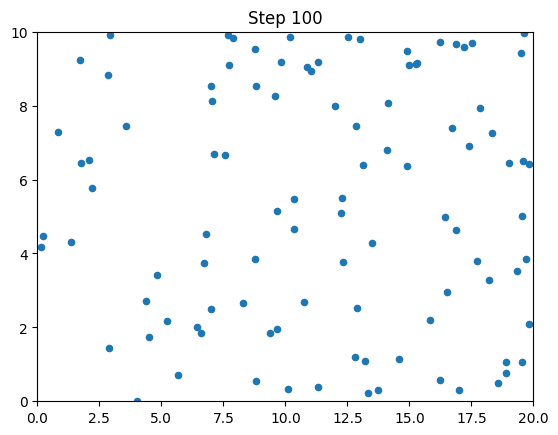

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

fig, ax = plt.subplots()  # Create a figure and axis for the plot
scat = ax.scatter([], [], s=20)  # Initialize empty scatter plot with marker size 20

ax.set_xlim(0, Lx)  # Set x-axis limits to match simulation box
ax.set_ylim(0, Ly)  # Set y-axis limits

def init():
    scat.set_offsets(np.empty((0, 2)))  # Initialize with empty 2D positions
    return scat,

def update(frame):
    positions = trajectory[frame]  # Get particle positions at current frame
    scat.set_offsets(positions)  # Update scatter plot positions
    ax.set_title(f"Step {frame}")  # Display step number in title
    return scat,

# Create the animation using your trajectory data
anim = FuncAnimation(fig, update, frames=len(trajectory), init_func=init, blit=True)

# Save the animation as a GIF
anim.save("displacement_trajectory.gif", writer='pillow', fps=5)

plt.show()


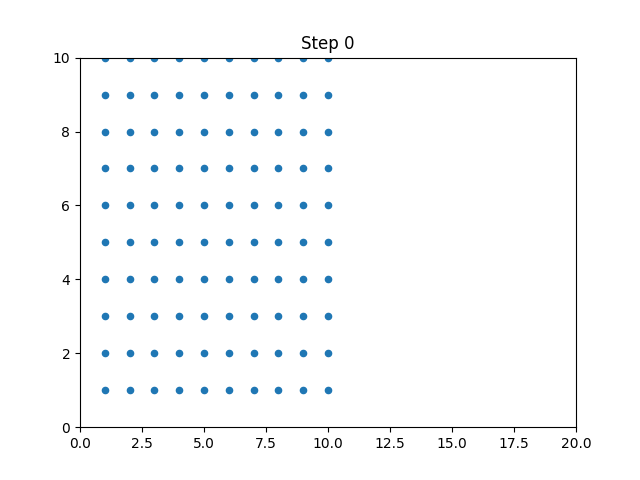

In [8]:
from IPython.display import Image
Image(filename="displacement_trajectory.gif")

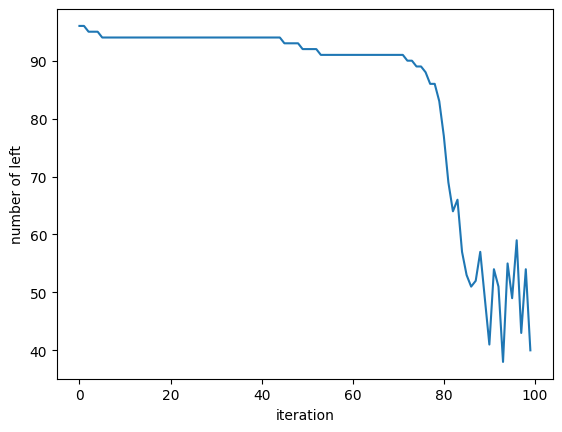

In [9]:
iteration=[]  # Create an empty list to store iteration numbers

for i in range(iter):  # Loop from 0 to iter-1
    iteration.append(i)  

plt.plot(iteration, left_particle)  # Plot number of particles on the left vs. iteration

plt.xlabel('iteration')  

plt.ylabel('number of left')  

plt.show() 


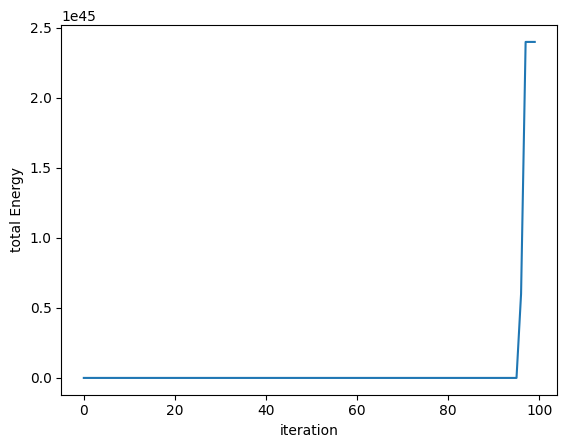

In [10]:
plt.plot(iteration, Energy)         # Plot total energy vs. iteration number

plt.xlabel("iteration")          

plt.ylabel('total Energy')         

plt.show()                          


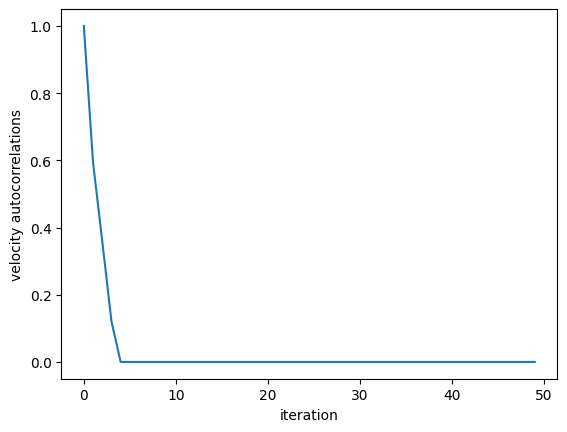

equilibration time= 4


In [11]:
velocity_autocorrelations=[]  # Store velocity autocorrelation for each lag
lag=[]  # Store lag times (time differences)

for t in range(iter//2):  # Limit lag to half the total time steps for better statistics
    velocity_autocorrelation_i=0  # Accumulate dot products for this lag
    step=0  # Count the number of contributions (for averaging)

    for i in range(len(velocity_track)):  # Loop over all time steps
        if i+t<len(velocity_track):  # Avoid going out of bounds
            for j in range(N):  # Loop over all particles
                step+=1  # Increment sample count
                # Compute velocity dot product at times i and i + t for particle j
                velocity_autocorrelation_i+=velocity_track[i][j][0]*velocity_track[i+t][j][0]+velocity_track[i][j][1]*velocity_track[i+t][j][1]

    velocity_autocorrelations.append(velocity_autocorrelation_i/step)  # Average autocorrelation
    lag.append(t)  # Store lag value
velocity_autocorrelations=np.array(velocity_autocorrelations)/velocity_autocorrelations[0]  # Normalize VACF
plt.plot(lag,velocity_autocorrelations)  # Plot VACF vs lag
plt.xlabel('iteration')  
plt.ylabel('velocity autocorrelations')  
plt.show()  
for i in range(len(velocity_autocorrelations)):  # Search VACF to find when it decays
    if velocity_autocorrelations[i]<0.05:  # Threshold for "near zero" VACF
        print('equilibration time=',i)  # Report approximate equilibration time
        break  # Stop at first drop below threshold



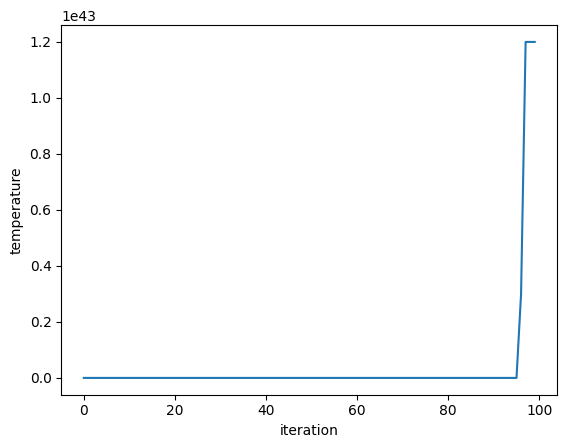

In [12]:
plt.plot(iteration, tempreture)  # Plot temperature vs. time step (iteration)
plt.xlabel("iteration")          
plt.ylabel('temperature')         
plt.show()                       

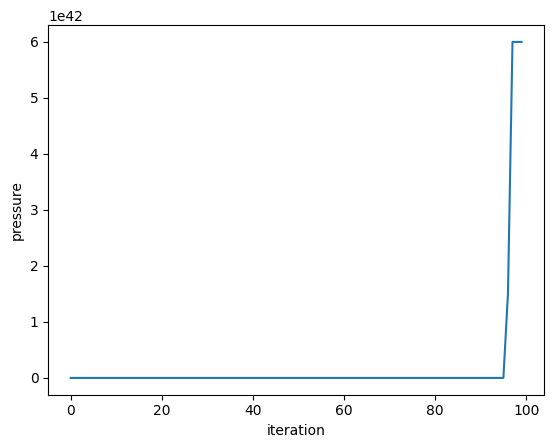

phase transition= 94


In [13]:
plt.plot(iteration, Pressure)  # Plot pressure vs. time step (iteration)

plt.xlabel("iteration")        

plt.ylabel('pressure')         

plt.show()                     
for i in range(len(Pressure)-2):  # Loop through pressure values
    if (Pressure[i+2]-Pressure[i+1])/(Pressure[i+1]-Pressure[i]) > 10**8:  # Detect very sharp change (possibly a phase transition)
        print('phase transition=', i)  # Report where the phase transition is suspected
        break  # Stop after the first detection



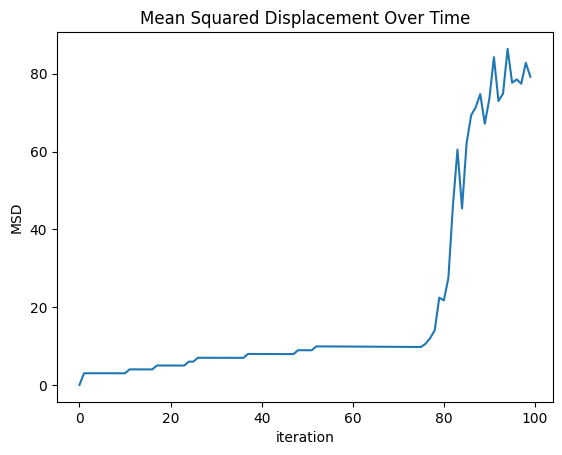

In [14]:
# Compute mean squared displacement (MSD) from trajectory data
displacment_change = []  # List to store displacements from initial frame
displacment = trajectory[0]  # Use first frame of trajectory as the reference position
MSD = []  # List to store MSD values over time

for i in trajectory:
    # Subtract initial position to get displacement at each time step
    displacment_change.append(np.array(i) - np.array(displacment))

for i in displacment_change:
    delta_r = 0  # Initialize squared displacement for this frame
    for j in i:
        delta_r += np.dot(j, j)  # Compute squared displacement for particle j
    MSD.append(delta_r / N)  # Average over all particles

# Plot the MSD vs iteration/time step
plt.plot(iteration, MSD[:-1])  # Exclude last point if iteration has len = iter
plt.xlabel("iteration")  
plt.ylabel("MSD")        
plt.title("Mean Squared Displacement Over Time")  
plt.show()  # Display the plot


Estimated diffusion coefficient D ≈ 0.0299


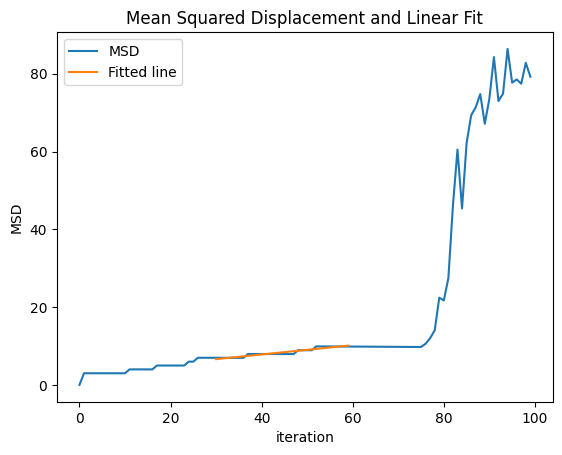

In [15]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Convert iteration and MSD to NumPy arrays
iteration = np.array(iteration)  # Time steps
MSD = np.array(MSD)              # Mean squared displacement values

# Select the linear region manually (adjust based on MSD plot)
start = 30  # Start index of approximately linear region
end = 60    # End index of linear region

X = iteration[start:end].reshape(-1, 1)  # Independent variable for regression (time)
y = MSD[start:end]                       # Dependent variable (MSD in selected range)

# Fit linear model to MSD = 4Dt in 2D
model = LinearRegression()
model.fit(X, y)  # Perform linear regression on selected portion

# Predict MSD values using fitted model (for plotting the fit)
y_pred = model.predict(X)

# Extract slope and compute diffusion coefficient
slope = model.coef_[0]  # Slope of MSD vs time
D = slope / 4  # Diffusion coefficient in 2D: MSD ≈ 4Dt

# Output the estimated diffusion coefficient
print(f"Estimated diffusion coefficient D ≈ {D:.4f}")

# Plot original MSD curve and fitted line on top
plt.plot(iteration, MSD[:-1], label='MSD')       # Full MSD curve
plt.plot(X, y_pred, label='Fitted line')         # Linear fit over selected region
plt.xlabel("iteration")                          # X-axis label
plt.ylabel("MSD")                                # Y-axis label
plt.title("Mean Squared Displacement and Linear Fit")  # Title
plt.legend()                                     # Show legend for clarity
plt.show()                                       # Display the plot


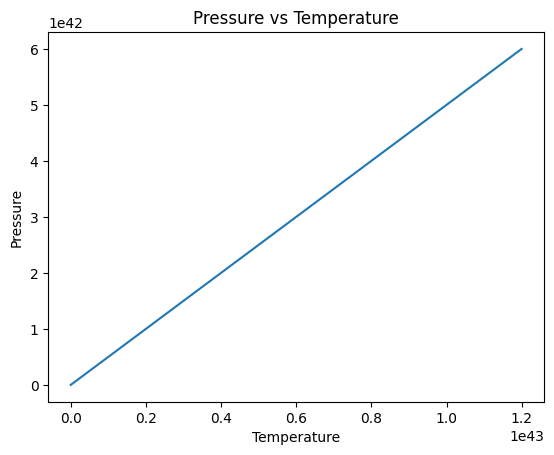

In [16]:
# Plot pressure as a function of temperature(van der valse relation)
plt.plot(tempreture, Pressure)  # Plot Pressure vs. Temperature
plt.xlabel("Temperature")       
plt.ylabel("Pressure")         
plt.title("Pressure vs Temperature") 
plt.show()                     


Estimated a ≈ 1547425049106725343623905280000.0
Estimated b ≈ 198.0


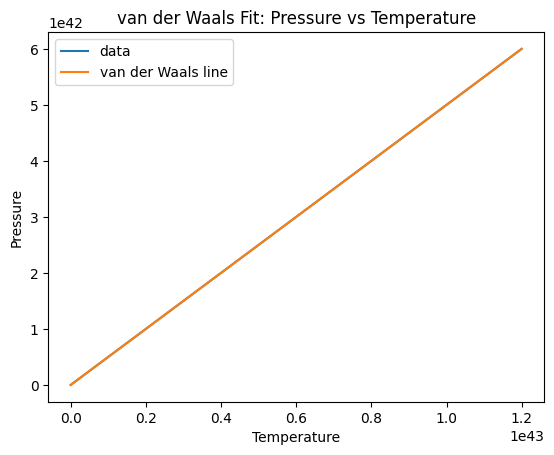

In [17]:
from sklearn.linear_model import LinearRegression

# Convert temperature and pressure lists to NumPy arrays
tempreture = np.array(tempreture) 
Pressure = np.array(Pressure)

# Prepare the feature (X) and target (y) variables for linear regression
X = tempreture.reshape(-1, 1)  # Reshape for scikit-learn: shape (n_samples, 1)
y = Pressure

# Fit a linear regression model: P = m*T + c
model = LinearRegression()
model.fit(X, y)

# Predict values for fitted line
y_pred = model.predict(X)

# Extract slope and intercept of the fitted line
slope = model.coef_[0]  # Slope m
intercept = model.intercept_  # Intercept c

# Compute van der Waals constants a and b using linear fit interpretation
b = (-1 / slope) + V           # b = V - (1/slope) based on vdW linearized form
a = -intercept * (V ** 2)      # a = -intercept * V² from linear regression

# Print estimated van der Waals constants
print(f"Estimated a ≈ {a:.1f}")
print(f"Estimated b ≈ {b:.1f}")

# Plot pressure vs. temperature with fitted van der Waals line
plt.plot(tempreture, Pressure, label='data')         # Raw data
plt.plot(X, y_pred, label='van der Waals line')      # Linear fit
plt.xlabel("Temperature")                            
plt.ylabel("Pressure")                               
plt.title("van der Waals Fit: Pressure vs Temperature")  
plt.legend()                                         
plt.show()                                           
